In [1]:

N = 64;
mid = round(N/2);
L = 70; % <-- [pc]
POINT_SPACING = 2*L/(N-1);

a = 1.3;
b = 10;
V0 = 0.0153; % <-- [pc/year]
R = 50; % <-- [pc]

t = 1300; % <-- [years]


In [2]:
% Final Eulerian mesh
[x, y, z] = meshgrid( linspace(-L,L,N), linspace(-L,L,N), linspace(-L,L,N) );

In [3]:
% final distance r
r = sqrt(x.^2 + y.^2 + z.^2);

In [4]:
% initial distance r0
r0 = arrayfun(@(my_r)initFromFin(my_r,t,a,b,R,V0), r);

In [5]:
% dr/dr0
dr_dr0 = arrayfun(@(my_r, my_r0)calc_dr_dr0(my_r,my_r0,a,b,R), r, r0);

In [6]:
% initial Lagrangian mesh
x0 = r0.*x./r;

y0 = r0.*y./r;

z0 = r0.*z./r;

if (mod(N,2)==1) % middle point giving nan
    dr_dr0(mid, mid, mid) = 1; 
    x0(mid, mid, mid) = 0;     
    y0(mid, mid, mid) = 0;     
    z0(mid, mid, mid) = 0;     
end

In [7]:
% useful graphing functions;
fastg = @(A) MeFancyGraph(x(:,:,end), y(:,:,end), A);
fastq = @(A, B) MeFancyQuiver(x(:,:,end), y(:,:,end), A, B);

In [8]:
% Derivatives and Jacobian

dx_dx0 = dr_dr0 .* (x0./r0).^2 + r./r0.*(1-(x0./r0).^2);
dy_dy0 = dr_dr0 .* (y0./r0).^2 + r./r0.*(1-(y0./r0).^2);
dz_dz0 = dr_dr0 .* (z0./r0).^2 + r./r0.*(1-(z0./r0).^2);

dx_dy0 = (dr_dr0 - r./r0) .* x0.*y0./r0.^2;
dy_dx0 = dx_dy0;

dx_dz0 = (dr_dr0 - r./r0) .* x0.*z0./r0.^2;
dz_dx0 = dx_dz0;

dy_dz0 = (dr_dr0 - r./r0) .* y0.*z0./r0.^2;
dz_dy0 = dy_dz0;

inv_J = arrayfun(@(A,B,C,D,E,F,G,H,I)1/det([A,B,C;D,E,F;G,H,I]),dx_dx0,dx_dy0,dx_dz0,dy_dx0,dy_dy0,dy_dz0,dz_dx0,dz_dy0,dz_dz0);

In [10]:
% Number densities
n0 = ones(N,N,N);
n = inv_J .* n0;
ne = n;
mean_ne = mean(mean(mean(ne)));
ngamma = n;
mean_ngamma = mean(mean(mean(ngamma)));

In [11]:
% Magnetic field
Bx0 = ones(N,N,N) / 2^0.5;
By0 = zeros(N,N,N)+cos(pi/L*x) / 2^0.5;
Bz0 = zeros(N,N,N)+sin(pi/L*x) / 2^0.5;
% Bx0 = ones(N,N,N);
% By0 = zeros(N,N,N);
% Bz0 = zeros(N,N,N);

Bx = inv_J .* (Bx0.*dx_dx0 + By0.*dx_dy0 + Bz0.*dx_dz0);
By = inv_J .* (Bx0.*dy_dx0 + By0.*dy_dy0 + Bz0.*dy_dz0);
Bz = inv_J .* (Bx0.*dz_dx0 + By0.*dz_dy0 + Bz0.*dz_dz0);


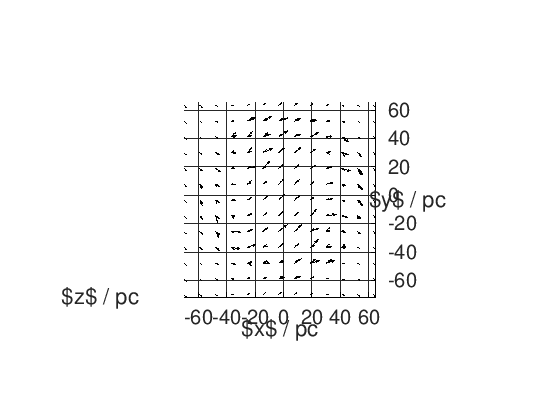

In [13]:
% % Quiver plot of Final Magnetic Field

each=5;

MeFancyQuiver3(x(1:each:end,1:each:end,1:each:end),y(1:each:end,1:each:end,1:each:end),z(1:each:end,1:each:end,1:each:end),Bx(1:each:end,1:each:end,1:each:end),By(1:each:end,1:each:end,1:each:end),Bz(1:each:end,1:each:end,1:each:end));

In [14]:
% Initial polarisation angles
psi0 = atan(By./Bx) + pi/2;

In [15]:
% OBSERVABLES
k = 0.81; % <-- Important quantity [rad / (m^2 cm^-3 microG pc)]
lambda1 = 0.03; % <-- Wavelength [m]
lambda2 = 0.06; % <-- Wavelength [m]

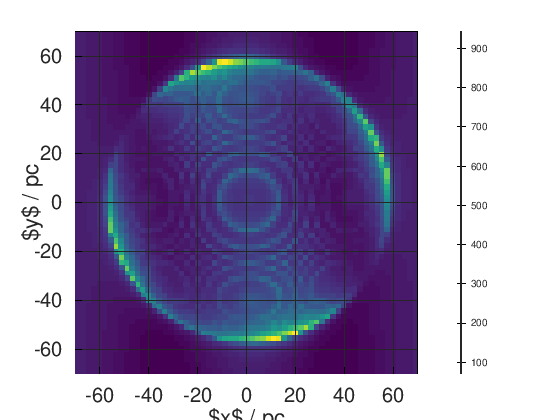

In [16]:
% Intensity

I = POINT_SPACING * trapz( ngamma.*(Bx.^2 + By.^2) , 3 );
% Integrate using trapezoidal method
%  - spacing between points is constant and is equal to POINT_SPACING
%  - the integrand as given in the formula
%  - integrating over 3rd axis (i.e. along z-axis)

MeFancyGraph(x(:,:,end), y(:,:,end), I);

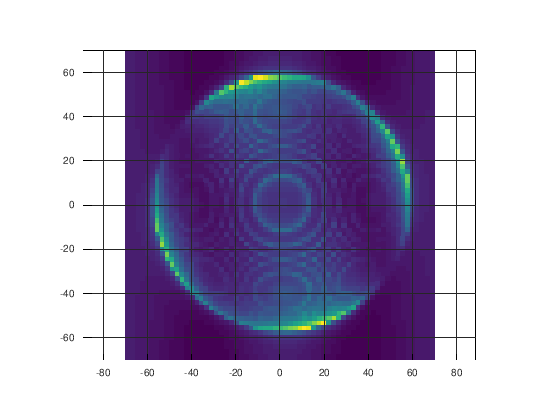

In [17]:
figure()
surf(x(:,:,end), y(:,:,end), I, 'EdgeColor', 'none');
axis equal;
view(0,90);

In [18]:
% Faraday rotation effect
F = k * POINT_SPACING * cumtrapz( ne .* Bz , 3 );

In [19]:
% Final Polarisation angle
psi1 = mod(psi0 + (lambda1^2)*F, pi);
psi2 = mod(psi0 + (lambda2^2)*F, pi);

In [20]:
% U and Q for 2 different wavelength
U1 = POINT_SPACING * trapz( ngamma .* (Bx.^2 + By.^2) .* sin(2*psi1) , 3 );
Q1 = POINT_SPACING * trapz( ngamma .* (Bx.^2 + By.^2) .* cos(2*psi1) , 3 );
% fastq(Q1, U1);

U2 = POINT_SPACING * trapz( ngamma .* (Bx.^2 + By.^2) .* sin(2*psi2) , 3 );
Q2 = POINT_SPACING * trapz( ngamma .* (Bx.^2 + By.^2) .* cos(2*psi2) , 3 );

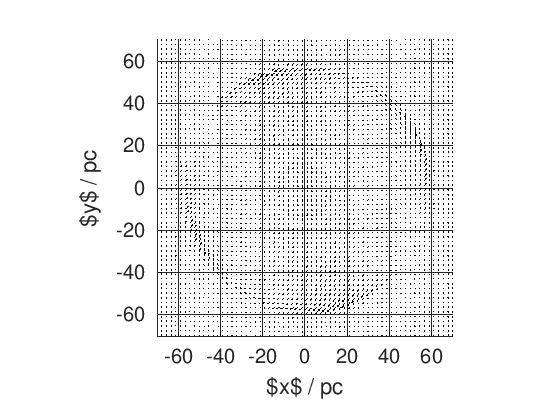

In [24]:
MeFancyQuiver(x(:,:,end), y(:,:,end), Q1,U1);
% figure();
% quiver(x(:,:,end), y(:,:,end), Q1,U1,'Color','black');
% axis equal;


In [25]:
% Final observable (averaged) polarisation angle
mean_psi1 = mod(0.5*atan(U1./Q1), pi);
mean_psi2 = mod(0.5*atan(U2./Q2), pi);
psi_diff = zeros(size(mean_psi1));
mean_mean_psi1 = mean(mean_psi1(:));
mean_mean_psi2 = chooseClosest(mean_mean_psi1, mean(mean_psi2(:)));

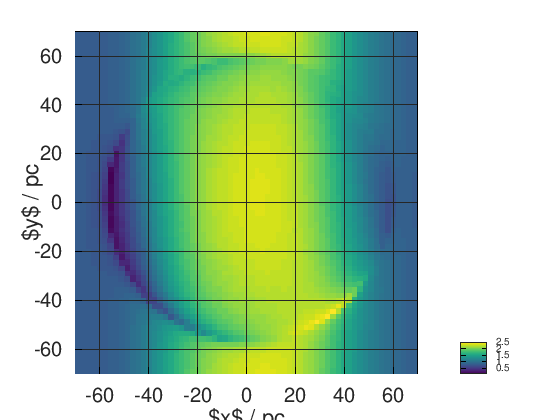

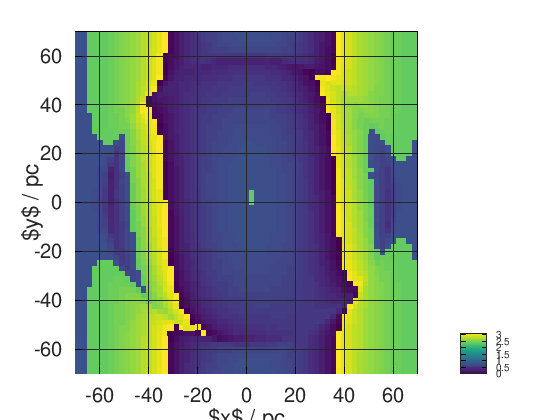

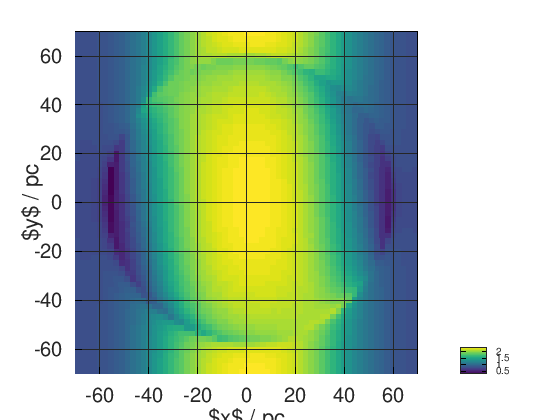

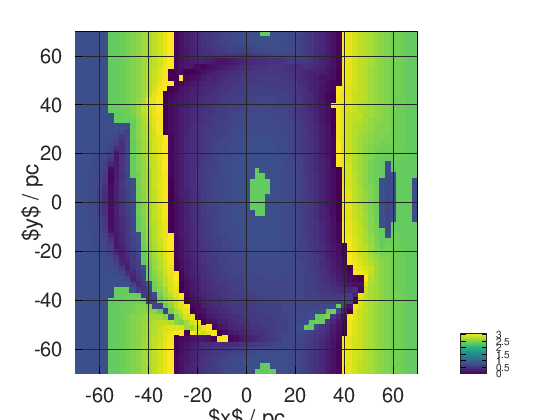

In [28]:

% WEIRD ANGLE ALLIGNMENT MAGIC
fastg(mean_psi1);
fastg(mean_psi2);

mean_psi1(1,1) = chooseClosest(mean_mean_psi1, mean_psi1(1,1));
mean_psi2(1,1) = chooseClosest(mean_mean_psi2, mean_psi2(1,1));
psi_diff(1,1) = mean_psi2(1,1) - chooseClosest(mean_psi2(1,1), mean_psi1(1,1));


for j=2:N
    mean_psi1(1,j) = chooseClosest(mean_psi1(1,j-1), mean_psi1(1,j));
    mean_psi2(1,j) = chooseClosest(mean_psi2(1,j-1), mean_psi2(1,j));
    psi_diff(1,j) = mean_psi2(1,j) - chooseClosest(mean_psi2(1,j), mean_psi1(1,j));
end

for i=2:N
    mean_psi1(i,1) = chooseClosest(mean_psi1(i-1,1), mean_psi1(i,1));
    mean_psi2(i,1) = chooseClosest(mean_psi2(i-1,1), mean_psi2(i,1));
    psi_diff(i,1) = mean_psi2(i,1) - chooseClosest(mean_psi2(i,1), mean_psi1(i,1));
    for j=2:N
        local_mean_psi1 = (mean_psi1(i-1,j) + mean_psi1(i,j-1)) / 2;
        local_mean_psi2 = (mean_psi2(i-1,j) + mean_psi2(i,j-1)) / 2;
        mean_psi1(i,j) = chooseClosest(local_mean_psi1, mean_psi1(i,j));
        mean_psi2(i,j) = chooseClosest(local_mean_psi2, mean_psi2(i,j));
        psi_diff(i,j) = mean_psi2(i,j) - chooseClosest(mean_psi2(i,j), mean_psi1(i,j));
    end
end

fastg(mean_psi1);
fastg(mean_psi2);

% fastg(psi_diff);


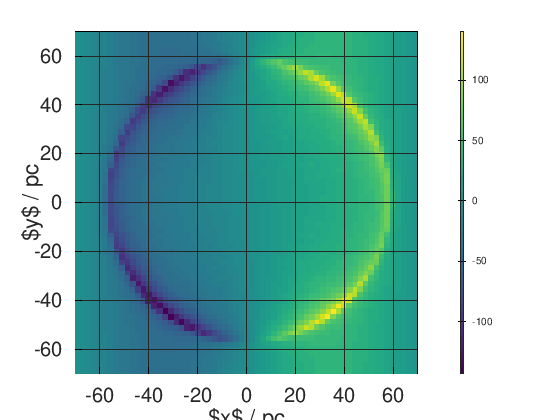

In [29]:

% Observed (averaged) Faraday's rotation measur
mean_F = (psi_diff) / (lambda2^2 - lambda1^2);
fastg(mean_F);


##  Calculations from observables


In [30]:
% Averaged Bz

% Averaged magnetic fields angles
mean_psi01 = mean_psi1 - lambda1^2*mean_F;
mean_psi02 = mean_psi2 - lambda2^2*mean_F;
mean_psi0 = (mean_psi01 + mean_psi02)/2;

In [31]:
% Averaged Bz
mean_Bz = 2 * mean_F / mean_ne / k / (2*L); 
% THERE MUST BE A FACTOR OF 2 IN FRONT SINCE WITHOUT IT, THIS VALUE IS
% ALWAYS A HALF OF REAL MEAN OF Bz ALONG Z-AXIS

In [32]:
% Averaged Bx and By
B_xy = sqrt(Bx.^2 + By.^2);
mean_Bxy = sqrt(I / mean_ngamma / (2*L));
mean_Bx = mean_Bxy .* cos(mean_psi0-pi/2);
mean_By = mean_Bxy .* sin(mean_psi0-pi/2);

In [33]:
% Averaged Jz
mean_Jz = zeros(N,N);
for i=2:N-1
   for j=2:N-1
       mean_Jz(i,j) = -sum(mean_Bx(i-1,j-1:j+1)) * ( x(i-1,j-1,end)-x(i-1,j+1,end) );
       mean_Jz(i,j) = mean_Jz(i,j) - sum(mean_Bx(i+1,j-1:j+1)) * ( x(i+1,j+1,end)-x(i+1,j-1,end) );
       mean_Jz(i,j) = mean_Jz(i,j) - sum(mean_By(i-1:i+1,j-1)) * ( y(i+1,j-1,end)-y(i-1,j-1,end) );
       mean_Jz(i,j) = mean_Jz(i,j) - sum(mean_By(i-1:i+1,j+1)) * ( y(i-1,j+1,end)-y(i+1,j+1,end) );
       mean_Jz(i,j) = mean_Jz(i,j) / abs(x(i-1,j-1,end)-x(i-1,j+1,end)) / abs(y(i+1,j-1,end)-y(i-1,j-1,end)) / 3;
   end
end
% THERE MUST BE A FACTOR OF 1/3 IN MEAN_J, I DON'T KNOW WHY IT SHOULD BE
% HERE, BUT IT SHOULD, BECAUSE WITHOUT IT MY MEAN_J IS 3 TIMES BIGGER THAN
% REAL [CURL_B]_z
% Z-component of Helicity -ish
Hz = mean_Jz .* mean_Bz;

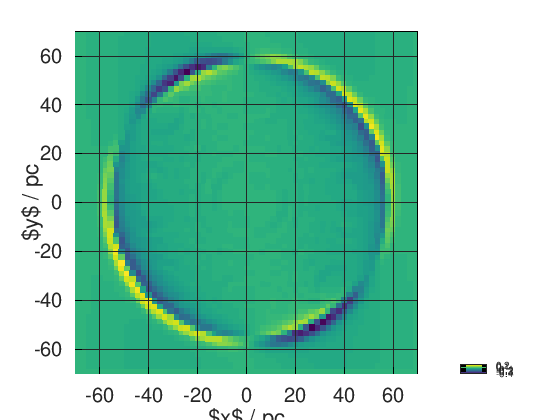

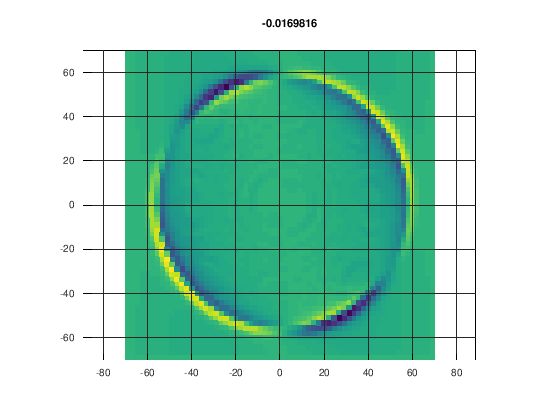

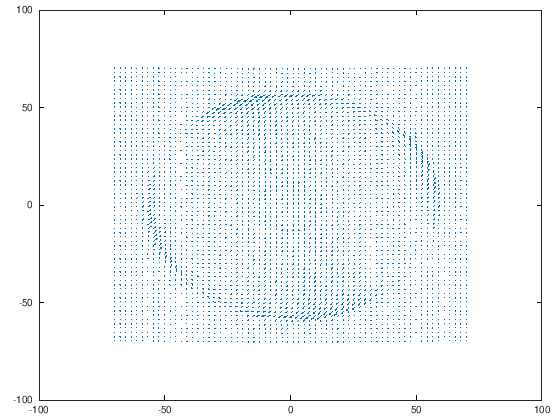

In [35]:

% Representation

figure();
quiver(x(:,:,end), y(:,:,end),Q1,U1);

figure();
surf(x(:,:,end), y(:,:,end), Hz, 'EdgeColor', 'none');
axis equal;
title(mean(Hz(:)));
view(0,90);
fastg(Hz);


In [36]:
% Misc
[dBx_x, dBx_y, dBx_z] = gradient(Bx, POINT_SPACING);
[dBy_x, dBy_y, dBy_z] = gradient(By, POINT_SPACING);
[dBz_x, dBz_y, dBz_z] = gradient(Bz, POINT_SPACING);

curl_Bx = dBz_y - dBy_z;
curl_By = dBx_z - dBz_x;
curl_Bz = dBy_x - dBx_y;

real_Hz = curl_Bz .* Bz;

mean_real_Hz = mean(real_Hz, 3);


In [37]:
% 
% figure();
% surf(x(:,:,end), y(:,:,end), mean_real_Hz, 'EdgeColor', 'none');
% axis equal;
% title(mean(mean_real_Hz(:)));
% view(0,90);

% fastg(mean_real_Hz);


Error = abs((Hz-mean_real_Hz)./mean_real_Hz);

Averaged_Total_Error = mean(mean(Error(2:N-1,2:N-1)));


